# ModelingToolkit

# 3 Моделирование дискретного поведения с IfElse 

До сих пор мы имели дело с непрерывным поведением систем, в которых не было резких возмущений. В реальных системах непрерывное поведение сочетается с дискретным поведением, когда какое-либо событие приводит к разного рода разрывам, нарушающим непрерывность решения. 

Самый простой тип событий - это такой, который происходит в конкретно заданный момент времени, поэтому их называют **time event**, события, управляемые временем, или временн*ы*е события. Например, отключение одного из элементов электрической цепи, инициализируемое временем, или изменение температуры нагрева, по заданному графику времени. Поскольку такие события привязаны ко времени, мы заранее знаем, когда они произойдут.

Другой тип событий - это **state event**, события, управляемые состояниями, или просто события состояний. Мы не знаем заранее, когда они произойдут, поскольку условием их возникновения являются достижение какой-либо переменной заданного порога. Когда произойдет пересечение траектории решения системы дифференциальных уравнений с границей разрыва мы не знаем, и для определения точного момента когда такое событие произойдет, требуются дополнительные вычисление.

На MTK события можно генерировать с помощью условных выражений. В текущих версиях для этого служит пакет [IfElse.jl](https://github.com/SciML/IfElse.jl), который предоставляет одну функцию `ifelse()`. Для записи простых условий можно использовать и логические выражения.

In [1]:
using ModelingToolkit, DifferentialEquations, Plots, IfElse

## 3.1 Time event

Динамика следующей системы описывается дифференциальным уравнением, которое изменяется в момент времени $t=2$. 

\begin{equation*}
 \begin{cases}
 \frac{dx}{dt} = 100 - x,  \text{если }t \le 2
\\
 2\frac{dx}{dt} = 25 - x,  \text{если }t>2
\end{cases}
\end{equation*}
$$x(0)=25$$

Запишем систему с использованием IfElse

In [2]:
@variables t x(t) = 25

der = Differential(t)
eqs = der(x) ~ IfElse.ifelse(t <= 2, (100 - x), (25 - x)/2)
    
@named  model = ODESystem(eqs, t)

Model model with 1 equations
States (1):
  x(t) [defaults to 25]
Parameters (0):

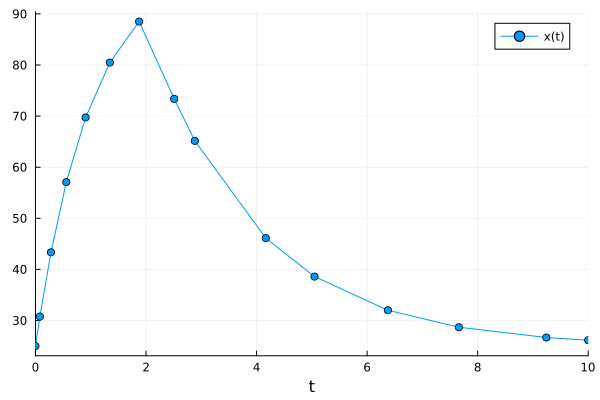

In [3]:
prob = ODEProblem(model, [], [0, 10])
sol = solve(prob)
plot(sol, denseplot=false, marker=:circle)

Как видно, переключение происходит, но не в момент $t=2$, решатель проскакивает его. Чтобы такого не происходило, укажем решателю явно, чтобы он делал шаг в эту точку, с помощью аргумента `tstops` в функции `solve()`

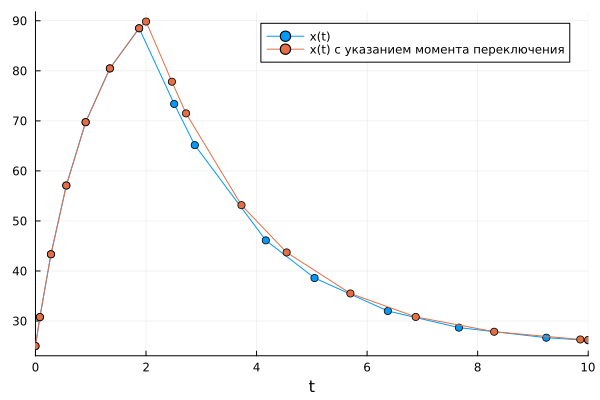

In [4]:
sol = solve(prob, tstops=[2])
plot!(sol, denseplot=false, marker=:circle, label="x(t) с указанием момента переключения")

* **Правило 1**: При моделировании временн*ы*х событий с помощью условных выражений, следует указывать решателю моменты времени, в которые они запланированы 

А что если записать условие в виде

\begin{equation*}
 \begin{cases}
 \frac{dx}{dt} = 100 - x,  \text{если }t < 2
\\
 2\frac{dx}{dt} = 25 - x,  \text{если }t \ge 2
\end{cases}
\end{equation*}
$$x(0)=25$$

в котором строгое неравенство заменено на нестрогое и наоборот

In [5]:
@variables t x(t)=25

der = Differential(t)
eqs = der(x) ~ IfElse.ifelse(t < 2, (100 - x), (25 - x)/2)
    
@named  model = ODESystem(eqs, t)

Model model with 1 equations
States (1):
  x(t) [defaults to 25]
Parameters (0):

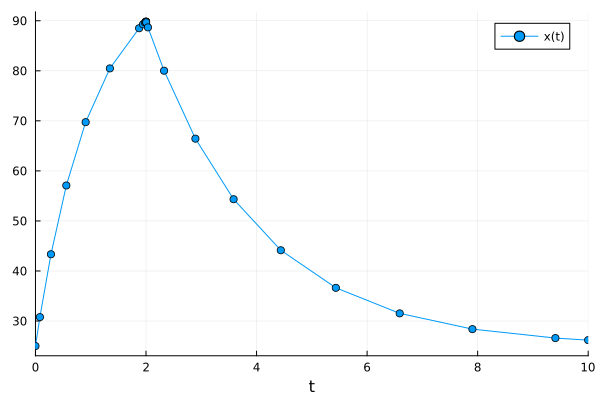

In [6]:
prob = ODEProblem(model, [], [0, 10])
sol = solve(prob, tstops=[2])
plot(sol, denseplot=false, marker=:circle)

Как видим, решатель делает много дополнительных шагов перед моментом $t=2$

* **Правило 2**: При моделировании временн*ы*х событий с помощью условных выражений, следует использовать знаки `≤` и `>`, но не наоборот

## 3.2 State event

Рассмотрим следующую систему, которая при $x>10$ описывается уравнениями

\begin{equation*}
 \begin{cases}
 \frac{dx}{dt} = 1 - x
\\
 10\frac{dy}{dt} = 10+xy
\end{cases}
\end{equation*}

а в противном случае уравнениями

\begin{equation*}
 \begin{cases}
 \frac{dx}{dt} = 1 - x
\\
 \frac{dy}{dt} = 0
\end{cases}
\end{equation*}



In [7]:
@variables t x(t)=40 y(t)=0
der = Differential(t)
eqs = [
    der(x) ~ 1 - x
    der(y) ~ IfElse.ifelse(x > 10, 1+0.1y*x, 0)
]
@named  model = ODESystem(eqs, t)

Model model with 2 equations
States (2):
  x(t) [defaults to 40]
  y(t) [defaults to 0]
Parameters (0):

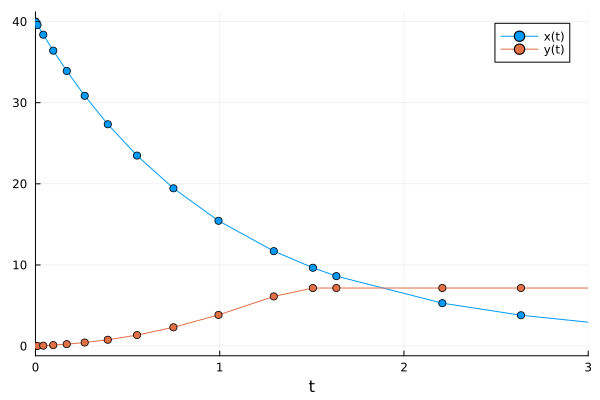

In [8]:
prob = ODEProblem(model, [], [0, 3])
sol = solve(prob)
plot(sol, denseplot=false, marker=:circle)

На графике видно, как решатель дробит шаг в окрестности $t\approx1.466$, чтобы найти момент пересечения решения с границей разрыва $x(t)=10$. Чем выше заданная точность расчета динамики, тем сильнее дробится шаг и точнее вычисляется момент события:

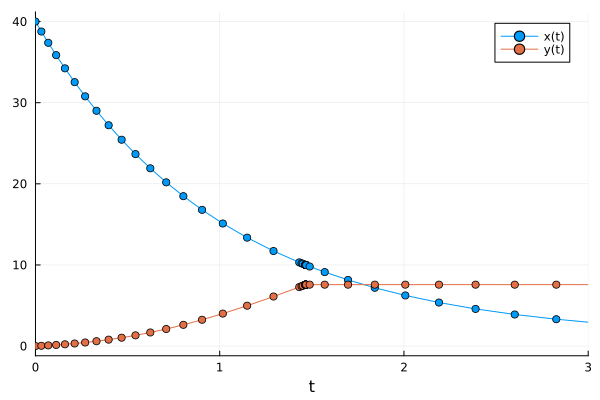

In [9]:
sol = solve(prob, abstol=1e-8, reltol=1e-8)
plot(sol, denseplot=false, marker=:circle)

## 3.3 Логические выражения vs условные выражения

Событие в последней системе можно сгенерировать и с помощью логического выражения

In [10]:
@variables t x(t)=40 y(t)=0
der = Differential(t)
eqs = [
    der(x) ~ 1 - x
    der(y) ~ (x > 10) * (1 + 0.1y*x)
]
@named  model = ODESystem(eqs, t)

Model model with 2 equations
States (2):
  x(t) [defaults to 40]
  y(t) [defaults to 0]
Parameters (0):

Здесь `(x > 10)` возвращает логический 0 или 1, и, таким образом, уравнение производной для $y$ будет `der(y) ~ 1 + 0.1y*x` или `der(y) ~ 0`

Получаемое решение абсолютно идентично решению, полученному с использованием if-else:

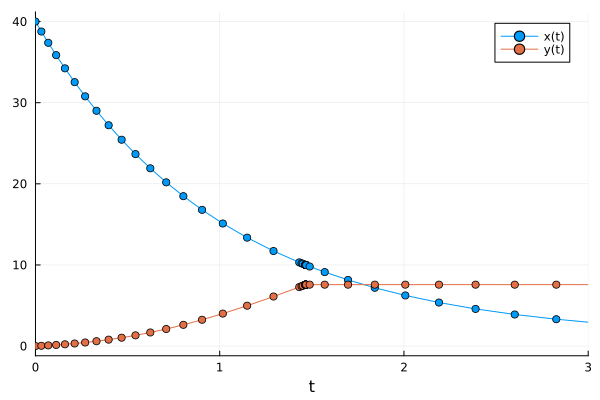

In [11]:
prob = ODEProblem(model, [], [0, 3])
sol = solve(prob, abstol=1e-8, reltol=1e-8)
plot(sol, denseplot=false, marker=:circle)

Рассмотрим другую систему

\begin{equation*}
 \begin{cases}
 \frac{dx}{dt} = -10 - x
\\
 \frac{dy}{dt}=\begin{cases}
  5\sqrt x, \text{если } x>0
\\
 0, \text{если } x\le0
\end{cases}
\end{cases}
\end{equation*}


In [12]:
@variables t x(t)=40 y(t)=0
der = Differential(t)

# Модель 1 с использованием if-else
eqs = [
    der(x) ~ - 10 - x
    der(y) ~ IfElse.ifelse(x > 0, 5*sqrt(x), 0)
]
@named model1 = ODESystem(eqs, t)

# Модель 2 с использованием логического выражения
eqs = [
    der(x) ~ - 10 - x
    der(y) ~ (x > 0)* (5*sqrt(x))
]
@named model2 = ODESystem(eqs, t)

Model model2 with 2 equations
States (2):
  x(t) [defaults to 40]
  y(t) [defaults to 0]
Parameters (0):

Если первая модель решается:

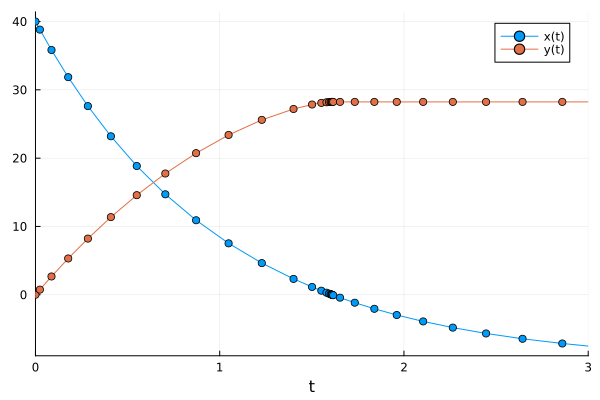

In [13]:
prob = ODEProblem(model1, [], [0, 3])
sol = solve(prob, abstol=1e-8, reltol=1e-8)
plot(sol, denseplot=false, marker=:circle)

То вторая модель выдает ошибку:

In [ ]:
prob = ODEProblem(model2, [], [0, 3])
sol = solve(prob, abstol=1e-8, reltol=1e-8)
plot(sol, denseplot=false, marker=:circle)

Этот пример демонстрирует отличие двух способов.

В первом случае выражение для производной `y` с √x участвует в расчете, только когда `x > 0`, а во втором случае √x вычисляется всегда, а при `x > 0` просто обнуляется

## 3.4 Примеры
### 3.4.1 Модель шарика падающего на пружину

![Image](https://reshimvse.com/img/1394476999u.png)
Модель описывается системой дифференциальных уравнений


\begin{equation*}
 \begin{cases}
 \frac{dy}{dt} = v
\\
 \frac{dv}{dt}=\begin{cases}
 -g, \text{если } y>L
\\
-g+K\frac{L-y}{m}, \text{если } y\le L
\end{cases}
\end{cases}
\end{equation*}

где $y$, $v$, $m$ - координата, скорость и масса шарика, $L$ и $K$ - длина (в недеформированном состоянии) и жесткость пружины, $g$ - ускорение свободного падения

В модели на MTK для последующей демонстрации добавим уравнение для пружины 
\begin{equation*}
y_s= \begin{cases}
 L, \text{если } y> L
\\
 y, \text{если } y\le L
\end{cases}
\end{equation*}

где $y_s$ - длина пружины

In [15]:
@variables t 

@parameters m = 1 [description="масса шарика"]
@parameters L = 3 [description="длина пружины"]
@parameters K = 200 [description="коэффициент упругости пружины"]

@constants g = 9.80665 [description="ускорение свободного падения"]

@variables y(t) = 10 [description="координата шарика"]
@variables v(t) = 0 [description="скорость шарика"]
@variables ys(t) = L [description="длина пружины"]


der = Differential(t)
eqs = [
    der(y) ~ v
    der(v) ~ IfElse.ifelse(y > L, -g, -g + K * (L - y) / m)
    ys ~ IfElse.ifelse(y > L, L, y)
]
@named Ball = ODESystem(eqs, t)
sys = structural_simplify(Ball)

Model Ball with 2 equations
States (2):
  y(t) [defaults to 10]: координата шарика
  v(t) [defaults to 0]: скорость шарика
Parameters (3):
  L [defaults to 3]: длина пружины
  K [defaults to 200]: коэффициент упругости пружины
  m [defaults to 1]: масса шарика
Incidence matrix:2×5 SparseArrays.SparseMatrixCSC{Num, Int64} with 4 stored entries:
 ⋅  ×  ×  ⋅  ⋅
 ×  ⋅  ⋅  ⋅  ×

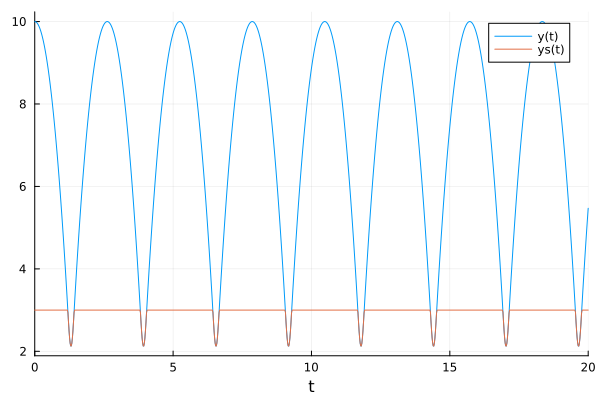

In [16]:
prob = ODEProblem(sys, [], [0, 20])
sol = solve(prob, abstol=1e-8, reltol=1e-8, saveat=0.02)
plot(sol, idxs=[y, ys])

[ Info: Saved animation to /home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif


Plots.AnimatedGif("/home/juser/MyProjects/Julia/Workshop_2023/ModelingToolkit/tmp.gif")
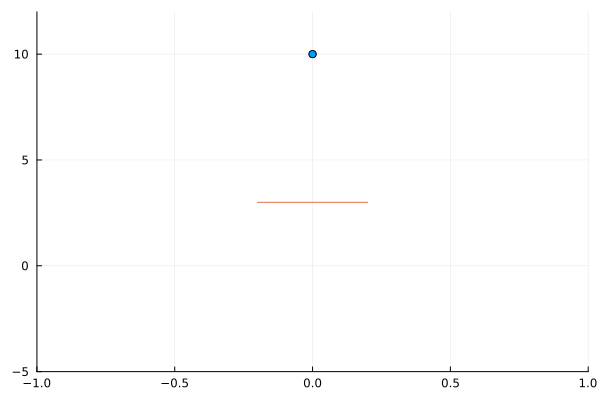

In [17]:
@gif for i in 1:1000
    plot([0,0], [sol[y][i], sol[y][i]], 
        label="", xlims=(-1,1), ylims=(-5.0,12), marker=:circle)
    plot!([-0.2, 0.2], [sol[ys][i], sol[ys][i]], label="")
end every 5

### 3.4.2 Электрическая цепь

#### Включение в заданный момент
Добавим временн*о*е событие в модель электрической цепи, подавая питание в момент $t=0.4$

![Image](http://ets.ifmo.ru/osipov/os1/3_2.files/image031.jpg)

\begin{equation*}
 \begin{cases}
   -i_1 + i_2 +i_L = 0 
   \\
   r_1 i_1 + r_2 i_2 =E
   \\
   u_L=L\frac{di_L}{dt}=r_2 i_2
 \end{cases}
\end{equation*}

где 

\begin{equation*}
E= \begin{cases}
   0, \text{если } t\le 0.4 
   \\
   10, \text{если } t>0.4 
 \end{cases}
\end{equation*}

In [18]:
@variables t 

@parameters r₁ = 0.2 [description="сопротивление резистора 1"]
@parameters r₂ = 0.2 [description="сопротивление резистора 2"]
@parameters L = 0.01 [description="индуктивность катушки"]

@variables i₁(t) = 0 [description="ток через резистор 1"]
@variables i₂(t) = 0 [description="ток через резистор 2"]
@variables iₗ(t) = 0 [description="ток через катушку"]
@variables E(t) = 0 [description="напряжение источника"]

der = Differential(t)
eqs = [
    i₁ ~ i₂ + iₗ
    E ~ r₁ * i₁ + r₂ * i₂
    L * der(iₗ) ~ r₂ * i₂
    E ~ (t>0.4) * 10
    ]

@named Circuit = ODESystem(eqs, t)

sys = structural_simplify(Circuit)

Model Circuit with 2 equations
States (2):
  iₗ(t) [defaults to 0]: ток через катушку
  i₂(t) [defaults to 0]: ток через резистор 2
Parameters (3):
  r₁ [defaults to 0.2]: сопротивление резистора 1
  r₂ [defaults to 0.2]: сопротивление резистора 2
  L [defaults to 0.01]: индуктивность катушки
Incidence matrix:2×3 SparseArrays.SparseMatrixCSC{Num, Int64} with 4 stored entries:
 ⋅  ×  ×
 ×  ⋅  ×

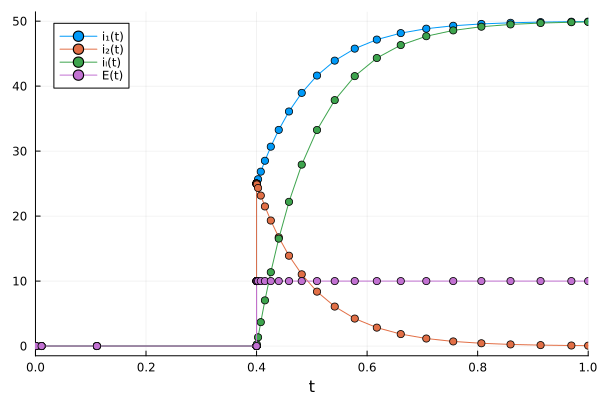

In [19]:
prob = ODEProblem(sys, [], [0.0, 1])
sol = solve(prob, tstops=[0.4])
plot(sol, idxs=[i₁, i₂, iₗ, E], denseplot=false, marker=:circle)

Заметим, что не все решатели справляются с этой задачей. Так, Rosenbrock23 демонстрирует выброс в момент события, а, например, QBDF1 не может продолжить расчет после события:


┌ Warning: dt(2.220446049250313e-16) <= dtmin(2.220446049250313e-16) at t=0.4. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase ~/.julia/packages/SciMLBase/VdcHg/src/integrator_interface.jl:589


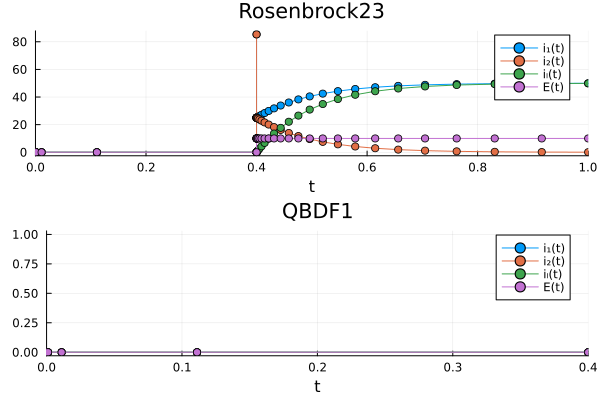

In [20]:
sol_ros = solve(prob, Rosenbrock23(), tstops=[0.4])
sol_bdf = solve(prob, QBDF1(), tstops=[0.4])

p_ros = plot(sol_ros, idxs=[i₁, i₂, iₗ, E], denseplot=false, marker=:circle, title="Rosenbrock23")
p_bdf = plot(sol_bdf, idxs=[i₁, i₂, iₗ, E], denseplot=false, marker=:circle, title="QBDF1")

plot(p_ros, p_bdf, layout=[1,1])

#### Включение и выключение в заданные моменты

In [21]:
#Самостоятельно: включение в t=0.4, отключение в t=1

### 3.4.3 Модель однополупериодного выпрямителя

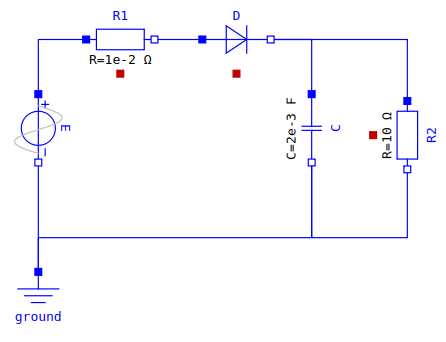

В данной схеме событием является переключение состояния диода. Когда напряжение на нем превышает пороговое значения $V_f$, он открывается и начинает пропускать ток. В противном случае он запирается.

\begin{equation*}
 \begin{cases}
   e = E\sin(2\pi f t)
   \\
   e = R_1 i_1 + R_2 i_2 + v_d
   \\
   v_c = R_2 i_2
   \\
   i_1 = i_2+i_c
   \\
   C\frac{dv_c}{dt}=i_c
   \\
   i_1 =  \begin{cases}
    v_d G_{\text{off}}, \text{  если } v_d<V_f
    \\
    \frac{v_d-V_f (1-R_{\text{on}}G_{\text{off}})}{R_{\text{on}}}, \text{  если } v_d\ge V_f
 \end{cases}
 \end{cases}
\end{equation*}


In [22]:
@variables t 

@parameters E = 10.0 [description="Амплитуда ЭДС источника"] 
@parameters R₁ = 1e-2 [description="Сопротивление источника"] 
@parameters R₂ = 10 [description="Сопротивление нагрузки"]   
@parameters C = 2e-3 [description="Емкость конденсатора"]
@parameters Vf = 0.6 [description="Пороговое напряжение, при котором диод открывается"]
@parameters Ron = 0.02 [description="Сопротивление диода в открытом состоянии"] 
@parameters Goff = 1e-8 [description="Проводимость диода в закрытом состоянии"] 

@variables i₁(t) = 0 [description="Ток через резистор R1"] 
@variables i₂(t) = 0 [description="Ток через нагрузку R2"] 
@variables ic(t) = 0 [description="Ток через конденсатор"] 
@variables e(t) = 0  [description="ЭДС источника"] 
@variables vd(t) = 0 [description="Напряжение на диоде"] 
@variables vc(t) = 0 [description="Напряжение на емкости"] 

der = Differential(t)
eqs = [
    e ~ E * sin(100π * t)
    e ~ R₁ * i₁ + R₂ * i₂ + vd
    i₁ ~ i₂ + ic
    ic ~ der(vc) * C
    vc ~ R₂ * i₂
    i₁ ~ IfElse.ifelse(vd < Vf, vd * Goff, (vd - Vf*(1-Ron*Goff)) / Ron)
    ]

@named Rectifier = ODESystem(eqs, t)
sys = structural_simplify(Rectifier)

Model Rectifier with 2 equations
States (2):
  vc(t) [defaults to 0]: Напряжение на емкости
  vd(t) [defaults to 0]: Напряжение на диоде
Parameters (7):
  E [defaults to 10.0]: Амплитуда ЭДС источника
  R₂ [defaults to 10]: Сопротивление нагрузки
  R₁ [defaults to 0.01]: Сопротивление источника
  C [defaults to 0.002]: Емкость конденсатора
  Goff [defaults to 1.0e-8]: Проводимость диода в закрытом состоянии
  Vf [defaults to 0.6]: Пороговое напряжение, при котором диод открывается
⋮
Incidence matrix:2×3 SparseArrays.SparseMatrixCSC{Num, Int64} with 5 stored entries:
 ×  ×  ×
 ×  ⋅  ×

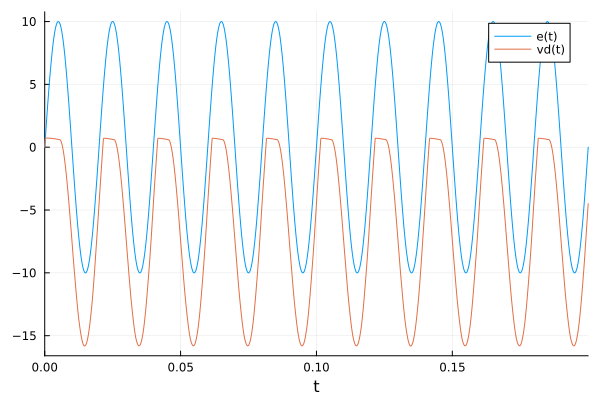

In [23]:
prob = ODEProblem(sys, [], [0, 0.2])
sol = solve(prob, reltol=1e-5)
plot(sol, idxs=[e, vd])

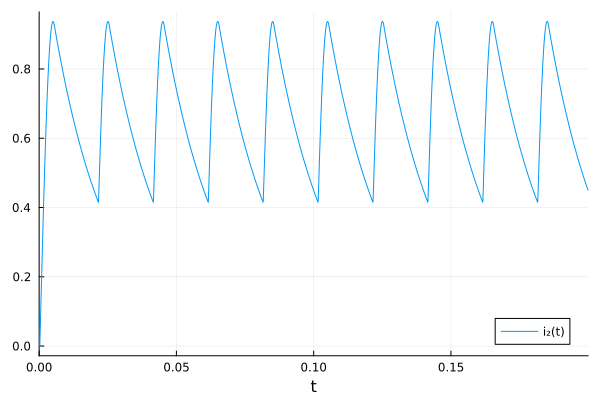

In [24]:
plot(sol, idxs=i₂)

Вольтамперная характеристика диода

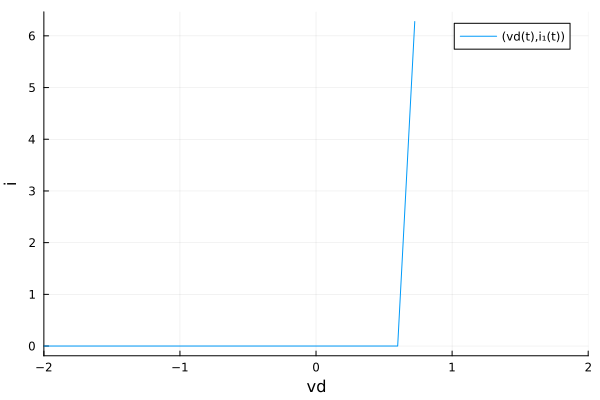

In [25]:
plot(sol, idxs=[(vd, i₁)], xlabel="vd", ylabel="i", denseplot=false, xlims=(-2,2))

## 3.5 Неожиданные решения (объяснить причину)

### 3.5.1 Пример 1
Вернемся к электрической цепи и смоделируем событие - изменение полярности источника, когда ток i1 превысит 40 А

In [26]:
@variables t 

@parameters r₁ = 0.2 
@parameters r₂ = 0.2 
@parameters L = 0.01 

@variables i₁(t) = 25
@variables i₂(t) = 25
@variables iₗ(t) = 0
@variables E(t) = 10 

der = Differential(t)
eqs = [
    0 ~ i₂ - i₁ + iₗ
    E ~ (r₁ * i₁ + r₂ * i₂)
    der(iₗ) ~ r₂ * i₂ / L
    E ~ IfElse.ifelse((i₁>0) & (i₁<40), 10, -10)
    ]
@named Circuit = ODESystem(eqs, t)

sys = structural_simplify(Circuit)

Model Circuit with 2 equations
States (2):
  iₗ(t) [defaults to 0]
  i₁(t) [defaults to 25]
Parameters (3):
  r₁ [defaults to 0.2]
  r₂ [defaults to 0.2]
  L [defaults to 0.01]
Incidence matrix:2×3 SparseArrays.SparseMatrixCSC{Num, Int64} with 5 stored entries:
 ×  ×  ×
 ×  ⋅  ×

При построении задачи с помощью ODEProblem все работает верно:

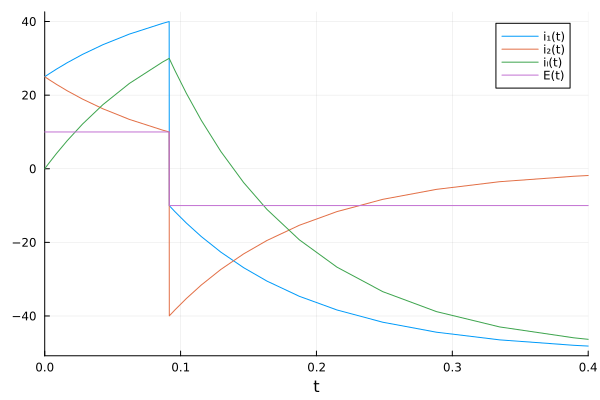

In [27]:
prob = ODEProblem(sys, [], [0.0, 0.4])
sol = solve(prob);
plot(sol, idxs=[i₁, i₂, iₗ, E], denseplot=false)

Но при построении с помощью ODAEProblem, решатель отказывается решать:

In [ ]:
prob = ODAEProblem(sys, [], [0.0, 0.4])
sol = solve(prob);
plot(sol, idxs=[i₁, i₂, iₗ, E], denseplot=false)

### 3.5.2 Пример 2

Здесь моделируется включение резистора параллельно r1 (т.е. уменьшения сопротивления r1 в 2 раза) в момент $t=0.4$

In [29]:
@variables t 
@variables i₁(t) = 50
@variables i₂(t) = 0
@variables iₗ(t) = 50

@parameters E = 10.0 
@parameters r₁ = 0.2 
@parameters r₂ = 0.2 
@parameters L = 0.01 

der = Differential(t)
eqs = [
    0 ~ i₂ - i₁ + iₗ
    E ~ IfElse.ifelse(t <= 0.4, r₁ * i₁ + r₂ * i₂, r₁/2 * i₁ + r₂ * i₂)
    der(iₗ) ~ r₂ * i₂ / L
    ]

@named Circuit = ODESystem(eqs, t)

sys = structural_simplify(Circuit)

Model Circuit with 2 equations
States (2):
  iₗ(t) [defaults to 50]
  i₁(t) [defaults to 50]
Parameters (4):
  E [defaults to 10.0]
  r₁ [defaults to 0.2]
  r₂ [defaults to 0.2]
  L [defaults to 0.01]
Incidence matrix:2×3 SparseArrays.SparseMatrixCSC{Num, Int64} with 5 stored entries:
 ×  ×  ×
 ×  ⋅  ×

При построении задачи с помощью ODEProblem решатель не может преодолеть событие, шаг мельчает и алгоритм останавливается:

In [30]:
prob = ODEProblem(sys, [], [0, 1])
sol = solve(prob, tstops=[0.4], reltol=1e-6)

if sol.retcode == ReturnCode.Success
    plot(sol, idxs=[i₁, i₂, iₗ], denseplot=false)
end

┌ Warning: dt(2.220446049250313e-16) <= dtmin(2.220446049250313e-16) at t=0.4. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase ~/.julia/packages/SciMLBase/VdcHg/src/integrator_interface.jl:589


Считает только при использовании алгоритма с постоянным шагом

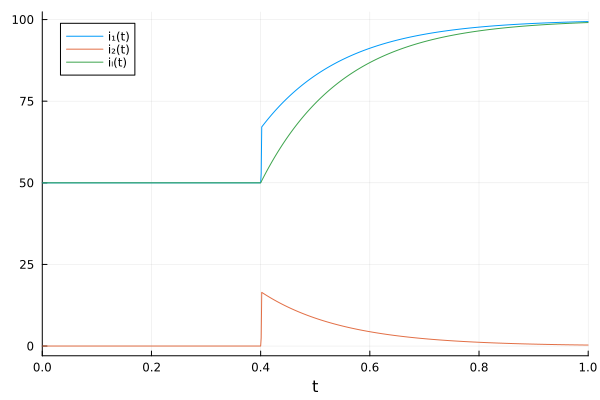

In [31]:
sol = solve(prob, Rodas4P(), tstops=[0.4], adaptive=false, dt=0.001, dense=false)

if sol.retcode == ReturnCode.Success
    plot(sol, idxs=[i₁, i₂, iₗ], denseplot=false)
end

C ODAEProblem все работает как надо:

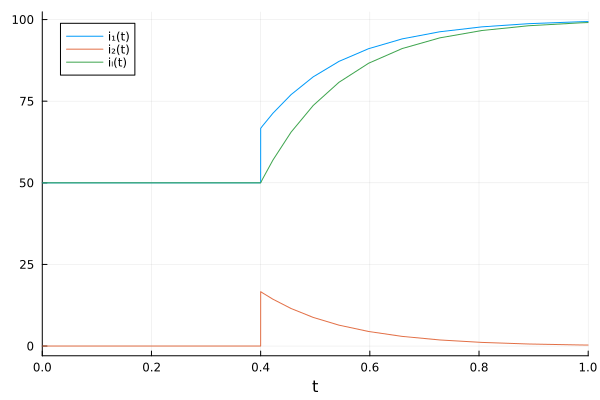

In [32]:
prob = ODAEProblem(sys, [], [0, 1])
sol = solve(prob, tstops=[0.4], reltol=1e-6)
plot(sol, idxs=[i₁, i₂, iₗ], denseplot=false)